In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
import os
import sys
import torch
import cv2
import shutil
import numpy as np
from PIL import Image, ImageDraw
from ultralytics import YOLO

from utils.utils import list_file_r, copy_image_to_sub_dir, create_yolo_annotation_from_mask
from utils.formating import yolo_to_coco

In [5]:
# can install package here if needed
"""
package_name = 'pillow' # enter package name here
!{sys.executable} -m pip install {package_name} """

"\npackage_name = 'pillow' # enter package name here\n!{sys.executable} -m pip install {package_name} "

In [7]:
# create yolo annotations from_mask and export to target folder
mask_data_path = 'datasets/CF_simulation/mask/line/photometric'
annotation_dst = 'datasets/CF_simulation/labels/line/photometric'
mask_pfs = list_file_r(mask_data_path, extension=['.tif', '.bmp', '.jpg', '.png'])
create_yolo_annotation_from_mask(mask=mask_data_path,out=annotation_dst)

# export YOLO segmentation format to a single COCO format json file
ann_folder = 'D:/xie/Vision/mcp_yolo/datasets/CF_simulation/labels/supp3'
img_folder = 'D:/xie/Vision/mcp_yolo/datasets/CF_simulation/images/supp3'
yolo_to_coco(folder=ann_folder, img_folder=img_folder)

# randomly select images for train/validation set
if False:
    image_data_path = 'datasets/CF_simulation/images/real/base'
    annotation_path = 'datasets/CF_simulation/labels/real/base'
    if not os.path.exists(image_data_path):
        os.makedirs(image_data_path)
    if not os.path.exists(annotation_path):
        os.makedirs(annotation_path)
    image_pfs = list_file_r(path=image_data_path, extension=['.tif'])

    rng = np.random.default_rng(seed=12345)
    sample_size, validation_ratio = len(image_pfs), 0.1

    selected_image_pfs = rng.choice(image_pfs, size=sample_size, replace=False)
    validation_image_pfs = selected_image_pfs[:int(sample_size*validation_ratio)]
    training_image_pfs = selected_image_pfs[int(sample_size*validation_ratio):]


    copy_image_to_sub_dir(training_image_pfs, sub_dir='train') 
    copy_image_to_sub_dir(validation_image_pfs, sub_dir='val')

In [ ]:

torch.cuda.empty_cache()
arguments={
    'epochs':100,
    'project': 'yolov9',
    'name':'base_largeData_e_640p_100e',
    'imgsz':640,
    #'epochs':20,
}
model = YOLO('yolov9e-seg.yaml')
results = model.train(data='train_augmented.yaml', **arguments)

In [2]:
import cv2
import time
img_path = 'datasets/CF_simulation/mask/real/0006.tif'
# Load the image
image = cv2.imread(img_path)

# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply thresholding
_, thresh = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY)

# Measure execution time
start_time = time.time()
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
end_time = time.time()

print("Time taken:", end_time - start_time)

Time taken: 0.0010006427764892578


In [7]:
# validation
#torch.cuda.empty_cache()
model = YOLO('real_image/largeData_large_640p_100e/weights/best.pt')
model = YOLO('runs/segment/base_largeData_large_640p_100e/weights/best.pt')
model = YOLO('RDA/largeData_large_640p_100e/weights/best.pt')
val_config = 'train_augmented.yaml'
#val_config = 'val_mb.yaml'
#val_config = 'val_defocus.yaml'
#val_config = 'val_shadow.yaml'
#val_config = 'val_photometric.yaml'
val_config = 'val_real_orig.yaml'
validation_results = model.val(data=val_config,
                               imgsz=640,
                               #batch=16,
                               #conf=0.8,
                               #iou=0.7,
                               )

Ultralytics YOLOv8.2.24  Python-3.11.6 torch-2.2.0+cu121 CUDA:0 (NVIDIA GeForce RTX 3090, 24576MiB)
YOLOv8l-seg summary (fused): 295 layers, 45912659 parameters, 0 gradients, 220.1 GFLOPs


val: Scanning D:\xie\Vision\mcp_yolo\datasets\CF_simulation\labels\real\original.cache... 23 images, 0 backgrounds, 0 corrupt: 100%|██████████| 23/23 [00:00<?, ?it/s]

val: WARNING  D:\xie\Vision\mcp_yolo\datasets\CF_simulation\images\real\original\0006.tif: 9 duplicate labels removed



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:08<00:00,  4.07s/it]


                   all         23        218      0.915      0.472      0.539      0.479      0.915      0.472      0.538      0.451
Speed: 2.7ms preprocess, 37.4ms inference, 0.0ms loss, 205.0ms postprocess per image
Results saved to runs\segment\val37


In [8]:
validation_results.seg.all_ap

array([[    0.53782,     0.53782,     0.50553,     0.46697,     0.46697,     0.45929,     0.45774,     0.45042,     0.39723,     0.22906]])

In [ ]:
# real image testing
torch.cuda.empty_cache()
#model = YOLO("RDA/largeData_large_640p_100e/weights/best.pt")
model = YOLO("runs/segment/base_largeData_large_640p_100e/weights/best.pt")
source = 'datasets/CF_simulation/real_image/test_gs/'
source = 'D:/xie/Vision/mcp_yolo/datasets/CF_simulation/images/line/base_large/val'
#source = 'D:/xie/Vision/mcp_yolo/datasets/CF_simulation/images/real'
#source = 'datasets/real_image/5.3/10x'
test_results = model.predict(source=source, save=True, project='real_image_test' ,name='paper', conf=0.7)

In [94]:
from utils.utils import save_mask_from_yolo_results
save_mask_from_yolo_results(test_results)

In [9]:
inference_results = model(source='datasets/CF_simulation/real_image/test_gs/', save=True, project='real_image_test' ,name='real_image_test', conf=0.70)


image 1/23 d:\xie\Vision\mcp_yolo\datasets\CF_simulation\real_image\test_gs\0006.tif: 512x640 6 hydrophobic areas, 161.0ms
image 2/23 d:\xie\Vision\mcp_yolo\datasets\CF_simulation\real_image\test_gs\01_line_Radius5_2_Density2000_2000_Width60_Reflection_0.tif: 640x640 8 hydrophobic areas, 17.0ms
image 3/23 d:\xie\Vision\mcp_yolo\datasets\CF_simulation\real_image\test_gs\1.tif: 640x640 6 hydrophobic areas, 16.0ms
image 4/23 d:\xie\Vision\mcp_yolo\datasets\CF_simulation\real_image\test_gs\2.tif: 640x640 4 hydrophobic areas, 17.0ms
image 5/23 d:\xie\Vision\mcp_yolo\datasets\CF_simulation\real_image\test_gs\2400.tif: 512x640 (no detections), 14.0ms
image 6/23 d:\xie\Vision\mcp_yolo\datasets\CF_simulation\real_image\test_gs\3.tif: 640x640 6 hydrophobic areas, 17.0ms
image 7/23 d:\xie\Vision\mcp_yolo\datasets\CF_simulation\real_image\test_gs\4.tif: 640x640 8 hydrophobic areas, 17.0ms
image 8/23 d:\xie\Vision\mcp_yolo\datasets\CF_simulation\real_image\test_gs\hdt5_0010.tif: 512x640 6 hydropho


image 1/1 d:\xie\Vision\mcp_yolo\datasets\CF_simulation\images\augmented\val\01_line_Radius4_2_Density1500_1000_Width50_Reflection_1.tif: 640x640 7 hydrophobic areas, 76.0ms
Speed: 2.0ms preprocess, 76.0ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)


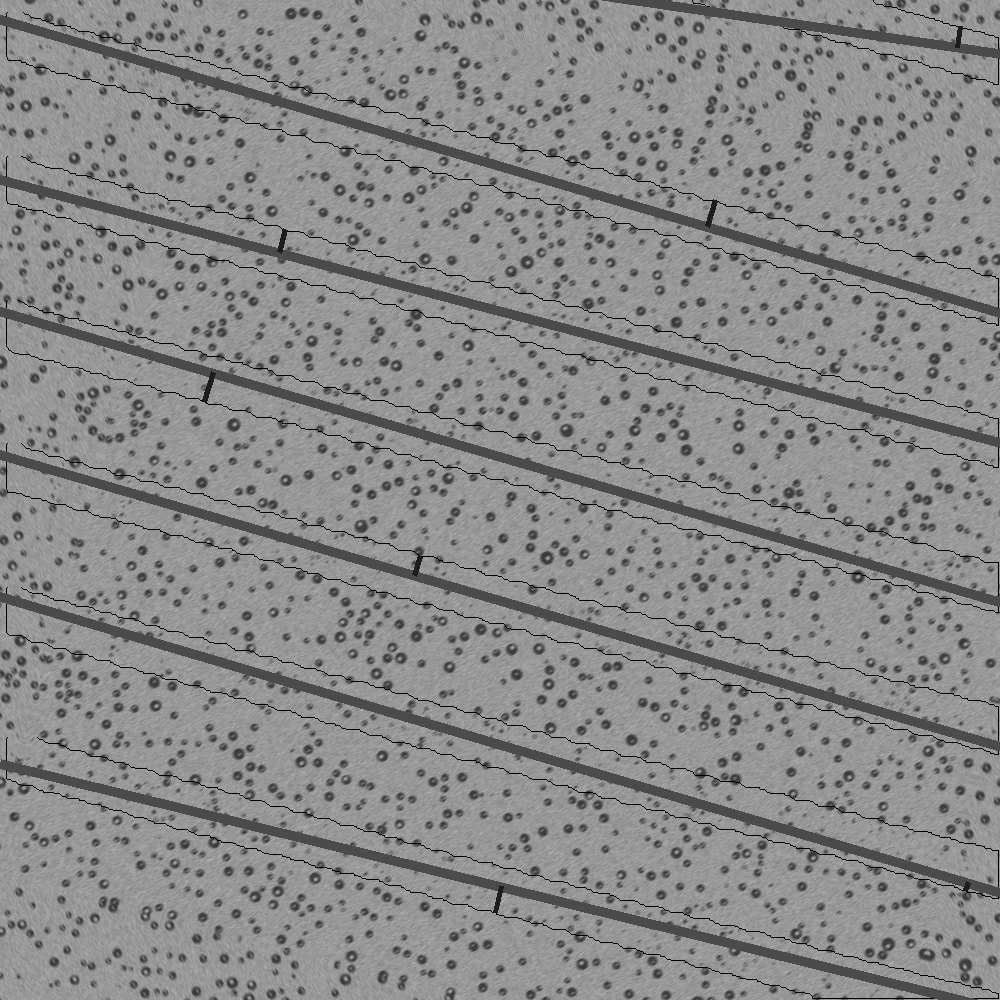

In [6]:
from utils.computation import calculate_widths, get_image_widths_by_path_names, draw_kernels

model = YOLO('RDA/largeData_large_640p_100e/weights/best.pt')
img_path = 'datasets/CF_simulation/images/augmented/val/01_line_Radius4_3_Density2000_1000_Width90_Reflection_1.tif'
img_path = 'datasets/CF_simulation/images/augmented/val/01_line_Radius4_2_Density1500_1000_Width50_Reflection_1.tif'

#inference_results = model(source='datasets/CF_simulation/images/val2/', save=True, project='validation_test', conf=0.70)
inference_results = model(source=img_path, save=False, project='validation_test', conf=0.70)
calculate_widths(inference_results)
draw_kernels(inference_results, img_path)

h50


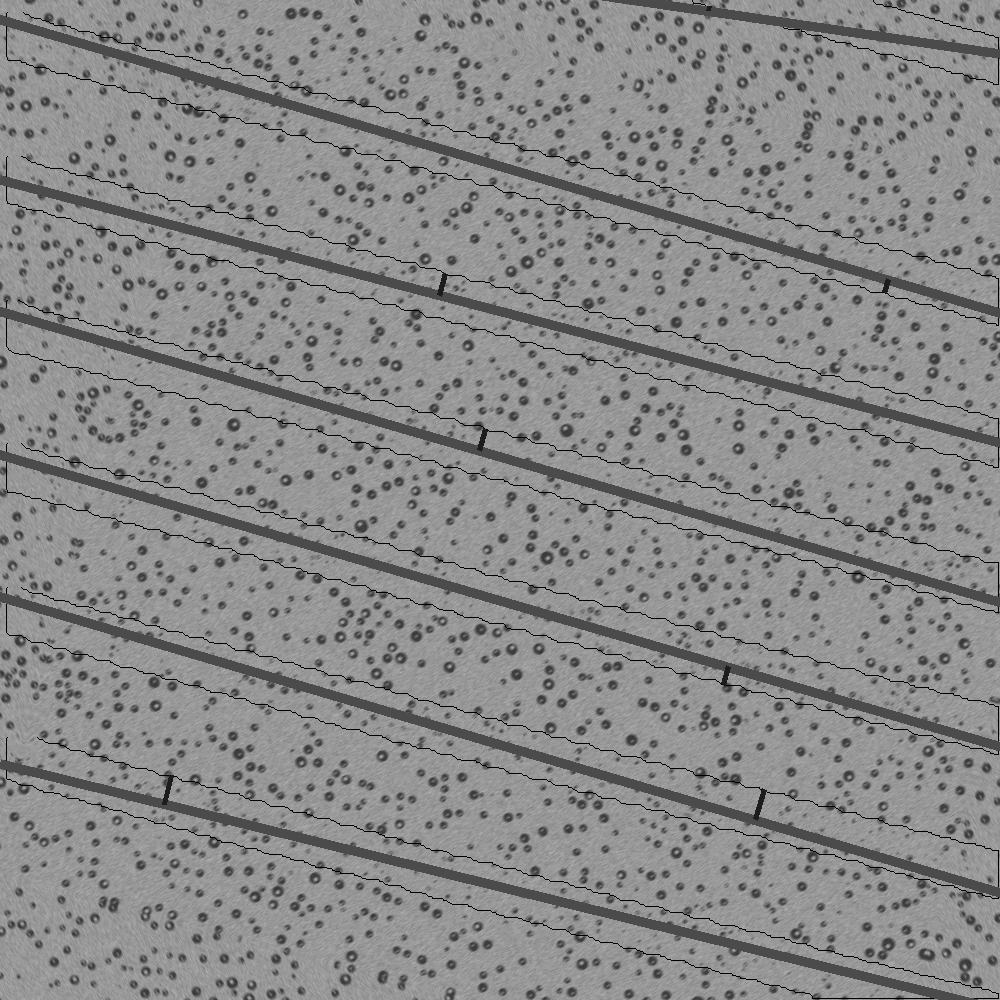

In [12]:
from utils.computation import draw_kernels

Image.open(inference_results[0].path).size
filename =os.path.splitext(os.path.split(inference_results[0].path)[-1])[0]
print((filename[39:42]))
draw_kernels(inference_results[0], inference_results[0].path)

In [25]:
import matplotlib.pyplot as plt
import time
#img = cv2.imread('datasets/CF_simulation/real_image/test/hdt5_0010.tif')
#img = Image.open('real_image_test/real_image_test/hdt5_1482.tif') 
img = Image.open('real_image_test/real_image_test7/01_line_Radius5_2_Density2000_2000_Width60_Reflection_0.tif') 
img = Image.open('datasets/CF_simulation/real_image/test_gs/0006.tif')
draw = ImageDraw.Draw(img) 
w, h = img.size

from utils.computation import calculate_widths, get_image_widths_by_path_names
predicted_widths = calculate_widths(inference_results=inference_results)
true_widths = get_image_widths_by_path_names(inference_results=inference_results)
print(predicted_widths.shape, true_widths.shape)
#filename =os.path.splitext(os.path.split(inference_results[1].path)[-1])[0]
#print(int(filename[40:42]))
#print(filename[40:].find('_'))
#print([inference_results[i].path for i in range(len(inference_results))])
#plt.imshow(img)
#plt.show()

(1, 1) (1, 1)


In [26]:
print(predicted_widths[:10], true_widths[:10])

[[   0.047288]] [[       0.05]]


In [27]:
# metrics 
errors = abs(predicted_widths - true_widths)/predicted_widths
np.quantile(errors, (0.1, 0.99))
errors.mean()

0.05735992899408005

(array([          0,           0,           0,           0,           0,           1,           0,           0,           0,           0]),
 array([   -0.44264,    -0.34264,    -0.24264,    -0.14264,    -0.04264,     0.05736,     0.15736,     0.25736,     0.35736,     0.45736,     0.55736]),
 <BarContainer object of 10 artists>)

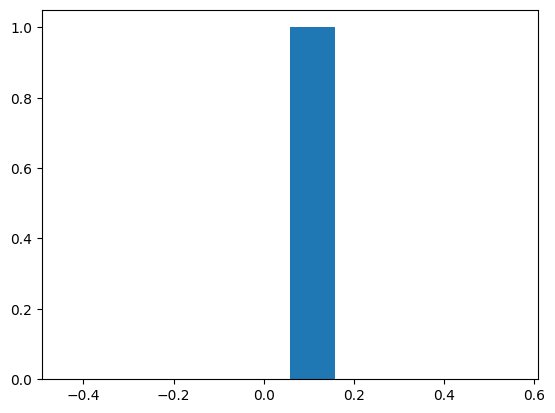

In [28]:
plt.hist(errors)

In [ ]:
import PIL.ImageOps as ImageOps
#test_result = model('datasets/CF_simulation/images/IMG10_sin_Radius7_4_Density1500_1000_Width50_Reflection_0_Curve1to20.tif')
#print(test_result)
#print(test_result[0].boxes)
model = YOLO('runs/segment/train/weights/best.pt')
test_img_path = 'datasets/CF_simulation/images/IMG10_sin_Radius7_4_Density1500_1000_Width50_Reflection_0_Curve1to20.tif'
test_result = model.predict(test_img_path, show=True, boxes=False)
#res_plotted = test_result[0].plot()
#print(test_result[0].boxes)
#cv2.imshow("result", res_plotted)
mask_seg = test_result[0].masks.data
print(mask_seg.data.shape)
#img = Image.open(test_img_path)
#mask = Image.fromarray(np.uint8(255*mask))
#seg_img = Image.fromarray(np.uint8(mask_seg.data.numpy()[0]))
#seg_img.show()
#img1 = img.paste(seg_img, (0, 0), seg_img)
#img = Image.fromarray(res_plotted)
#img1.show()
import torchvision.transforms as T
im = np.array(Image.new('RGB', (640, 640), (0,0,0)))
for seg in mask_seg:
    current = T.ToPILImage()(seg).convert('RGB')
    #current = ImageOps.invert(current)
    current = np.array(current)
    print(current)
    im += current
    #im.paste(current)
im = Image.fromarray(im)
#im = ImageOps.invert(im)
im.show()